In [1]:
%matplotlib inline

### Exact Riemann solver for SOD problem. 


Adapted from the listing given in reference [1].


[1] - Toro, E.F., Riemann Solvers and Numerical Methods for Fluid Dynamics: A Practical Introduction, 3rd Ed., Springer


In [2]:
import sys
from math import sqrt
import numpy as np

# Gammas
gamma = 1.4
g1 = (gamma - 1.0)/(2.0 * gamma)
g2 = (gamma + 1.0)/(2.0 * gamma)
g3 = 2.0 * gamma / (gamma - 1.0)
g4 = 2.0 / (gamma - 1.0)
g5 = 2.0 / (gamma + 1.0)
g6 = (gamma - 1.0)/(gamma + 1.0)
g7 = (gamma - 1.0)/2.0
g8 = gamma - 1.0


def test_pressure_positivity(cL, cR, uL, uR):
    if (g4*(cL+cR) <= (uR-uL)):
        print ("Riemann Exact: Vacuum generated by data!")
        sys.exit()


def guessp(dL, dR, uL, uR, pL, pR, cL, cR):
    quser = 2.0
    cup = 0.25*(dL + dR)*(cL + cR)
    ppv = 0.5*(pL + pR) + 0.5*(uL - uR)*cup
    ppv = max(0.0, ppv)
    pmin = min(pL, pR)
    pmax = max(pL, pR)
    qmax = pmax/pmin

    if (
        qmax <= quser and 
        (
            pmin <= ppv and
            ppv <= pmax
        )
    ):
        # Select PVRS Riemann Solver
        return ppv
    else:
        # Select Two-Rarefaction Riemann Sover
        if ppv < pmin:
            pq = (pL/pR)**g1
            uM = (pq*uL/cL + uR/cR + g4*(pq - 1.0))/(pq/cL + 1.0/cR)
            ptL = 1.0 + g7*(uL - uM)/cL
            ptR = 1.0 + g7*(uM - uR)/cR
            return 0.5*(pL*ptL**g3 + pR*ptR**g3)
        else:
            # Select Two-Shock Riemann Solver with
            # PVRS as estimate
            geL = sqrt((g5/dL)/(g6*pL + ppv))
            geR = sqrt((g5/dR)/(g6*pR + ppv))
            return (geL*pL + geR*pR - (uR - uL))/(geL + geR)


def star_pu(dL, dR, uL, uR, pL, pR, cL, cR):
    tol_pre = 1.0e-6
    nr_iter = 20
    
    p_start = guessp(dL, dR, uL, uR, pL, pR, cL, cR)
    print ("p_start: %s" % p_start)

    p_old = p_start
    u_diff = uR - uL

    for i in range(1, nr_iter+1):
        fL, fLd = prefun(p_old, dL, pL, cL)
        fR, fRd = prefun(p_old, dR, pR, cR)
        p = p_old - (fL + fR + u_diff)/(fLd + fRd)
        change = 2.0*abs((p-p_old)/(p+p_old))
        if change <= tol_pre:
            break
        if p < 0.0:
            p = tol_pre
        p_old = p
    u = 0.5*(uL + uR + fR - fL)
    return p, u


def prefun(pT, dk, pk, ck):
    if pT <= pk:
        # Rarefaction wave
        prat = pT/pk
        f = g4*ck*(prat**g1 - 1.0)
        fd = (1.0/(dk*ck))*prat**(-g2)
        return f, fd
    else:
        # Shock wave
        ak = g5/dk
        bk = g6*pk
        qrt = sqrt(ak/(bk+pT))
        f = (pT-pk)*qrt
        fd = (1.0 - 0.5*(pT - pk)/(bk + pT))*qrt
        return f, fd


def sample(pM, uM, s):
    if s <= uM:
        if pM <= pL:
            shL = uL - cL
            if s <= shL:
                d = dL
                u = uL
                p = pL
            else:
                cmL = cL*(pM/pL)**g1
                stL = uM - cmL
                if s > stL:
                    d = dL*(pM/pL)**(1.0/gamma)
                    u = uM
                    p = pM
                else:
                    u = g5*(cL + g7*uL + s)
                    c = g5*(cL + g7*(uL - s))
                    d = dL*(c/cL)**g4
                    p = pL*(c/cL)**g3
        else:
            pmL = pM/pL
            sL = uL - cL*sqrt(g2*pmL + g1)
            if s <= sL:
                d = dL
                u = uL
                p = pL
            else:
                d = dL*(pmL + g6)/(pmL*g6 + 1.0)
                u = uM
                p = pM
    else:
        if pM > pR:
            pmR = pM/pR
            sR = uR + cR*sqrt(g2*pmR + g1)
            if s >= sR:
                d = dR
                u = uR
                p = pR
            else:
                d = dR*(pmR + g6)/(pmR*g6 + 1.0)
                u = uM
                p = pM
        else:
            shR = uR + cR
            if s >= shR:
                d = dR
                u = uR
                p = pR
            else:
                cmR = cR*(pM/pR)**g1
                stR = uM + cmR
                if s <= stR:
                    d = dR*(pM/pR)**(1.0/gamma)
                    u = uM
                    p = pM
                else:
                    u = g5*(-cR + g7*uR + s)
                    c = g5*(cR - g7*(uR - s))
                    d = dR*(c/cR)**g4
                    p = pR*(c/cR)**g3
    return d, u, p
    

if __name__ == "__main__":
    
    #Tube length
    dom_len = 1.0
    
    #Diaphram position
    diaph = 0.5
    
    #Number of cells
    cells = 1000    #100
    
    #Output time
    time_out = 0.1

    
    # Sod Test
    
    #Initial condition to the left of the diaphram
    dL = 1.0
    uL = 0.0
    pL = 1.0
    
    #Initial condition to the right of the diaphram
    dR = 0.125
    uR = 0.0
    pR = 0.1
    
    #Compute temperature from initial conditions
    tL=pL/(dL*287.058)
    tR=pR/(dR*287.058)
    
    #Compute sound speed form initila conditions
    cL = sqrt(gamma*pL/dL)
    cR = sqrt(gamma*pR/dR)

    #dS = 0.0
    #uS = 0.0
    #pS = 0.0

    test_pressure_positivity(cL, cR, uL, uR)
    pM, uM = star_pu(dL, dR, uL, uR, pL, pR, cL, cR)
    print ("pM, uM: %s, %s" % (pM, uM))

    
    #Arrays containing solution
    pos_array = []
    rho_array = []
    pre_array = []
    vel_array = []
    s_array = []

    dx = dom_len/cells
    
    
    for i in range(1, cells+1):
        x_pos = (float(i) - 0.5)*dx
        s = (x_pos - diaph)/time_out
        d, u, p = sample(pM, uM, s)
        
        pos_array.append(x_pos)
        rho_array.append(d)
        pre_array.append(p)
        vel_array.append(u)
        s_array.append(s)
     

    
    
    '''
    riem_file = open("riemann_exact.csv", "w")
    
    for i in range(1, cells+1):
        x_pos = (float(i) - 0.5)*dx
        s = (x_pos - diaph)/time_out
        d, u, p = sample(pM, uM, s)
        
        riem_file.write("%s,%s,%s,%s\n" % 
            (d, u, p, p/d/g8))
            
    riem_file.close()
    '''

p_start: 0.31526852260996635
pM, uM: 0.30313017805064424, 0.9274526028125225


In [3]:
#For xkcd style
#plt.xkcd()

In [4]:
#Temperature computation
p_np=np.asarray(pre_array)
rho_np=np.asarray(rho_array)
pos_np=np.asarray(pos_array)
temp_np = p_np/(rho_np*287.058)

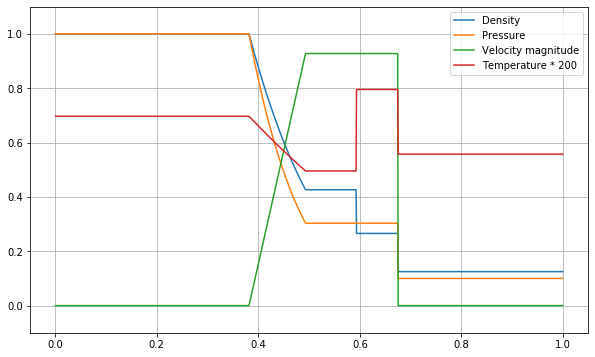

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.plot(pos_array,rho_array,label='Density')
plt.plot(pos_array,pre_array,label='Pressure')
plt.plot(pos_array,vel_array,label='Velocity magnitude')

plt.plot(pos_np,temp_np*200,label='Temperature * 200')

#plt.xlim([0,1])
plt.ylim([-0.1,1.1])

plt.legend()
plt.grid()

#plt.savefig('exact_solution.png', dpi=100)

In [6]:
#Read in openfoam solution
#cols = np.loadtxt('../postProcessing/sampleDict/0.1/data_T_mag(U)_p.xy')

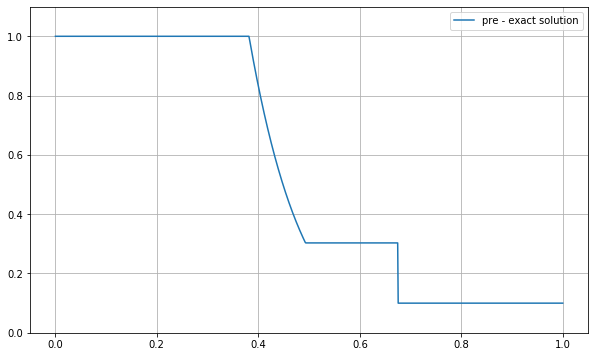

In [7]:
plt.figure(figsize=(10,6))

plt.plot(pos_array,pre_array,label='pre - exact solution')
#plt.plot(cols[:,0],cols[:,3],c='red',label='pre - openfoam')

#plt.xlim([0,1])
plt.ylim([0,1.1])

plt.legend(loc=0)
plt.grid()

#plt.savefig('pre.png', dpi=100)

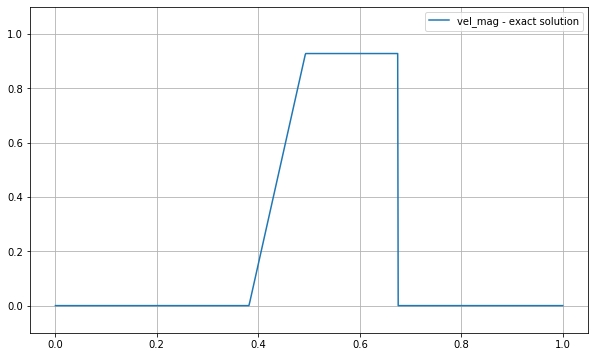

In [8]:
plt.figure(figsize=(10,6))

plt.plot(pos_array,vel_array, label='vel_mag - exact solution')
#plt.plot(cols[:,0],cols[:,2],c='red', label='vel_mag - openfoam')

#plt.xlim([0,1])
plt.ylim([-0.1,1.1])

plt.legend(loc=0)
plt.grid()

#plt.savefig('vel_mag.png', dpi=100)

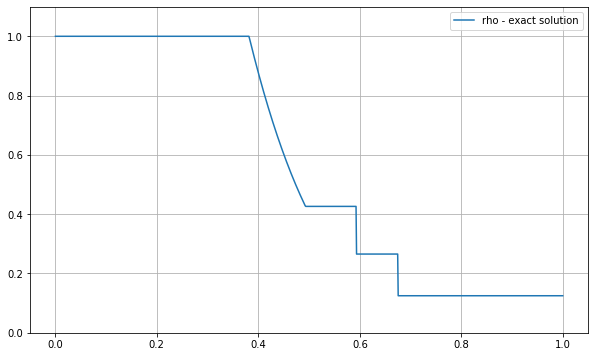

In [9]:
plt.figure(figsize=(10,6))

plt.plot(pos_array,rho_array, label='rho - exact solution')
#plt.plot(cols[:,0],cols[:,3]/(cols[:,1]*287.058),c='red',label='rho - openfoam')

#plt.xlim([0,1])
plt.ylim([0,1.1])

plt.legend(loc=0)
plt.grid()

#plt.savefig('rho.png', dpi=100)

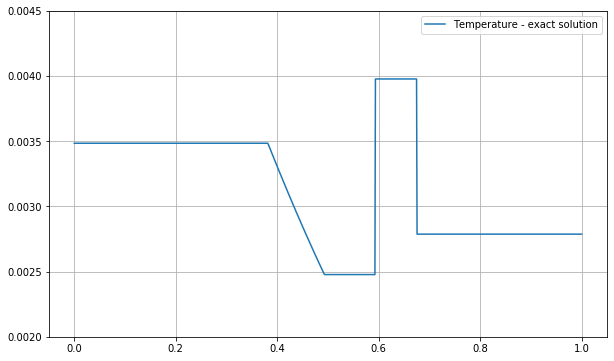

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

#p_np=np.asarray(pre_array)
#rho_np=np.asarray(rho_array)
#pos_np=np.asarray(pos_array)
#temp_np = p_np/(rho_np*287.058)

plt.plot(pos_np,temp_np,label='Temperature - exact solution')
#plt.plot(cols[:,0],cols[:,1],c='red',label='Temperature - openfoam')

#plt.xlim([0,1])
plt.ylim([0.002,0.0045])

plt.legend(loc=0)
plt.grid()

#plt.savefig('temp.png', dpi=100)